## Modelling Beveridge Curve(s)

This noteboook is an extension of the Main Project file, where we use the daily digital index created there to model the relationship between vacancies and unemployment, also known as a [Beveridge Curve](https://en.wikipedia.org/wiki/Beveridge_curve). This relaitonship was first established by Dow & Dick-Mireaux in 1958, and their original paper can be found [here](https://academic.oup.com/oep/article-abstract/10/1/1/2360055?redirectedFrom=fulltext). In short, the theory says there is a negative, convex relationship between vacancies and unemployment where an increase in vacancies leads to a decrease in unemployment, since there are more jobs the unemployed can choose from.

The notebook will begin by creating a general curve for the whole data, covering vacancies for all occupation in all of Sweden. This is then followed by a deaggregation per occupation, with the relationship being examined for different occupational groups.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
#plot configurations
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

### Query SQlite
The files have been channeled through an SQlite database (see file SQLite3_db in repository). This enables us to efficiently query the amount of active job ads, meaning ads that have passed publication date but not applicaiton deadline a certain date.  

In [ ]:
conn = sqlite3.connect("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/muni.db")
cursor = conn.cursor()
columns = []

#Finding the number of active ads per given time period
for year in range(2006,2021):
    for month in range(1,13):
# We have to skip first month since some groups have values of zero #
        if year == 2006 and month == 1:
            continue
        for day in range(1, calendar.monthrange(year, month)[1]+1):
            if day < 10 and month < 10:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-0{month}-0{day}' >= publication_date AND '{year}-0{month}-0{day}' <= application_deadline GROUP BY municipality_group;"
            elif month < 10 and day >9:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-0{month}-{day}' >= publication_date AND '{year}-0{month}-{day}' <= application_deadline GROUP BY municipality_group;"
            elif day < 10 and month >9:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-{month}-0{day}' >= publication_date AND '{year}-{month}-0{day}' <= application_deadline GROUP BY municipality_group;"
            else:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline GROUP BY municipality_group;"

            data = cursor.execute(query).fetchall()
            ads_per_day = [f'{year}-{month}-{day}', data[0][0], data[1][0], data[2][0], data[3][0], data[4][0], data[5][0], data[6][0], data[7][0], data[8][0]]
            columns.append(ads_per_day)

conn.close()
job_df = pd.DataFrame(columns[1:], columns=columns[0])
df.head()

### Combining with Statistics Sweden's Quarterly Vacancy Survey

As a first step, we will compare the relationship between vacancies and unemployment using Statistic Sweden's measure of vacancies. Their [quarterly vacancy survey](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__AM__AM0701__AM0701A/KV15LedigajobbVak07/) does not contain that many observations, yet should give a first indication of the relationship between these two variables.

In [5]:
#Loading the neccessary data sets
job_df = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/results.csv", names=["Date", "Vacancies"])
job_df = job_df.set_index(pd.to_datetime(job_df['Date'])).drop('Date', axis=1)
unemp = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/unem.csv", delimiter=",", names=["Date", "unemployed"])
unemp = unemp.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q')).drop("Date", axis=1)
working = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/anställda.csv", names=["Date", "working"])
working = working.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q')).drop("Date", axis=1)
labor_survey = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/lediga_jobb.csv").drop('quarter', axis=1)
labor_survey = labor_survey.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q'))
unem_rate = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/unemp_rate.csv", delimiter=",", names=["Date", "unemployed"])
unem_rate = unem_rate.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q')).drop("Date", axis=1)
unemp_rate = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/unemp_rate_M.csv", delimiter=",", names=["Date", "unemployment rate"])
unemp_rate = unemp_rate.set_index(pd.date_range('2006-03-31','2020-09-30', freq='M')).drop("Date", axis=1)
vac_rate = pd.DataFrame((labor_survey.iloc[:,0]/working.iloc[:,0]))/10

Text(0.0, 1.0, 'Quarterly Survey Vacancy rate vs Unemployment rate')

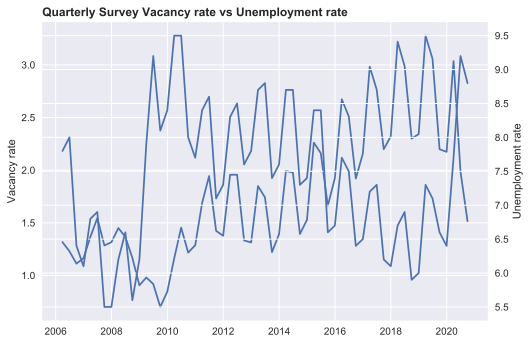

In [6]:
plt.plot(vac_rate)
plt.ylabel("Vacancy rate")
plt.twinx()
plt.plot(unem_rate)
plt.ylabel("Unemployment rate")
plt.title('Quarterly Survey Vacancy rate vs Unemployment rate', loc='left',fontweight='heavy')

### First impression of data

When plotting the quarterly versions of the unemployment rate and the survey based vacancy rate, we notice two things:

1. There is substantial seasonal variation in both series that will not help in modelling their relation
2. The year immediatly after the Great Financial Crisis saw an unprecedented level of unemployment that can be considered an outlier

These two issues will be handled when modelling the relation between the digital job ads index and unemployment, however in regards to the quarterly vacancy survey and unemployment an unadjusted version will be compared to an adjusted one to see if there is a substantial difference. 

Text(0.0, 1.0, 'Survey based job ads Beveridge Curve - non-seasonally adjusted')

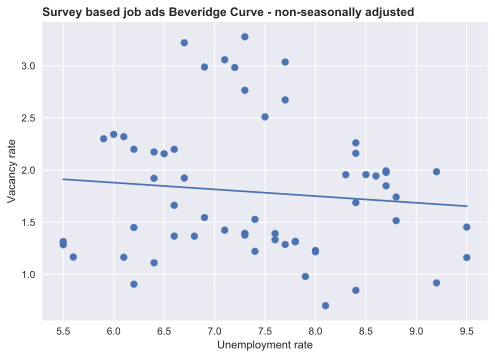

In [7]:
#Plotting with rates - vacancies divided by amount of working individuals and unemployed divided by the labor force
p = np.poly1d(np.polyfit(unem_rate.iloc[:,0], vac_rate.iloc[:,0], deg=1))
plt.scatter(unem_rate.iloc[:,0], vac_rate.iloc[:,0])
plt.plot(unem_rate.iloc[:,0], p(unem_rate.iloc[:,0]))
plt.ylabel("Vacancy rate")
plt.xlabel("Unemployment rate")
plt.title('Survey based job ads Beveridge Curve - non-seasonally adjusted', loc='left',fontweight='heavy')

The unadjusted version of the survey vacancy rate and unemployment shows a significant amount of noise and almost no relation between the two series, so we will go on and remove the seasonal effect using LOESS.

In [8]:
#Using LOESS to remove the seasonal effect from both series
stl = STL(vac_rate, period=4)
vac_q = stl.fit()
stl_1 = STL(unem_rate, period=4)
unemp_q = stl_1.fit()

seasonal_vac, trend_vac, resid_vac = vac_q.seasonal, vac_q.trend, vac_q.resid
seasonal_unem, trend_unem, resid_unem = unemp_q.seasonal, unemp_q.trend, unemp_q.resid
pred_unem = trend_unem + resid_unem
pred_vac = trend_vac + resid_vac

Text(0.0, 1.0, 'Survey based job ads Beveridge Curve - seasonally adjusted')

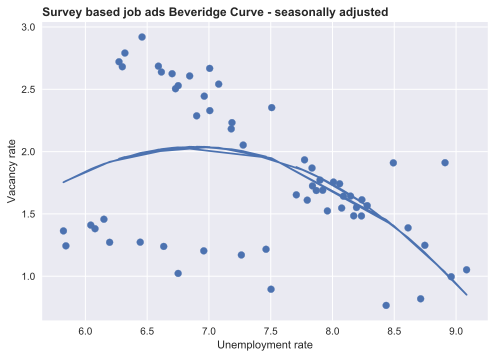

In [9]:
#plotting using a quadratic relationship - all data
p = np.poly1d(np.polyfit(pred_unem, pred_vac, deg=2))
plt.scatter(pred_unem, pred_vac)
plt.plot(pred_unem, p(pred_unem))
plt.ylabel("Vacancy rate")
plt.xlabel("Unemployment rate")
plt.title('Survey based job ads Beveridge Curve - seasonally adjusted', loc='left',fontweight='heavy')

Removing the seasonall effect made the relation much more clear but not as expected: the curve is concave rather than the expected convex relationship. This relationship is hard to interpret economically. Upon close inspection this seems to be due to the concetrated amount of high unemployment rate that was due to the financial crisis of 2008. We therefore move on with a version that excludes this outlier.

Text(0.0, 1.0, 'Survey based job ads Beveridge Curve - seasonally adjusted')

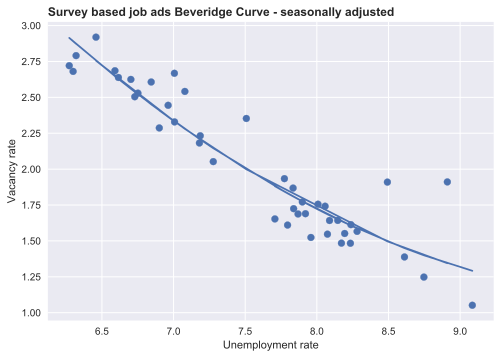

In [10]:
#plotting using a quadratic relationship - data from 2010
vac_slice = pred_vac[16:]
unem_slice = pred_unem[16:]
p = np.poly1d(np.polyfit(unem_slice, vac_slice, deg=2))
plt.scatter(unem_slice, vac_slice)
plt.plot(unem_slice, p(unem_slice))
plt.ylabel("Vacancy rate")
plt.xlabel("Unemployment rate")
plt.title('Survey based job ads Beveridge Curve - seasonally adjusted', loc='left',fontweight='heavy')

This seasonally adjusted version using data from 2010 shows the expected negative, slightly convex relationship between the vacancy rate and the unemployment rate, and the relation is quite clear. We will therefore use the same transformations when we modell the relationship between the digital job ads index and monthly unemployment rate below. 

In [12]:
#Resampling daily labor demand index and quarterly working individuals to monthly 
#so that they can compared to monthly unemployment rate
working_M = working.resample('M').mean()
working_M = working_M.fillna(working_M.bfill())
job_df_m = job_df.resample('M').mean()
job_df_m = job_df_m.fillna(job_df_m.bfill())
job_df_M = job_df_m[2:-3]
vac_rate_M = pd.DataFrame(job_df_M.iloc[:,0]/working_M.iloc[:,0])/10
vac_rate_M = vac_rate_M.rename(columns={0:'vacancy rate'})
#The slices excludes observations from the financial crisis 2008
slice_vac = vac_rate_M[40:]
slice_unem = unemp_rate[40:]

In [13]:
stl = STL(slice_vac, period=12)
vac_M = stl.fit()
stl_1 = STL(slice_unem, period=12)
unemp_M = stl_1.fit()

seasonal_vac_M, trend_vac_M, resid_vac_M = vac_M.seasonal, vac_M.trend, vac_M.resid
seasonal_unem_M, trend_unem_M, resid_unem_M = unemp_M.seasonal, unemp_M.trend, unemp_M.resid
pred_unem_M = trend_unem_M + resid_unem_M
pred_vac_M = trend_vac_M + resid_vac_M

Text(0.0, 1.0, 'Digital job ads Beveridge Curve - seasonally adjusted')

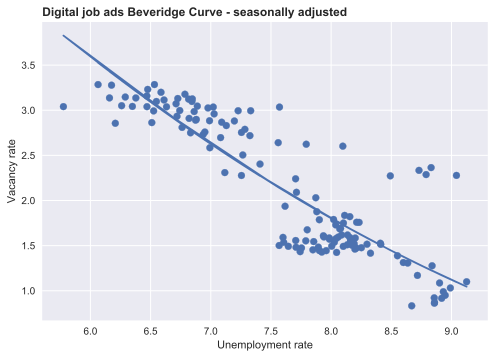

In [14]:
p = np.poly1d(np.polyfit(pred_unem_M, pred_vac_M, deg=2))
plt.scatter(pred_unem_M, pred_vac_M)
plt.plot(pred_unem_M, p(pred_unem_M))
plt.ylabel("Vacancy rate")
plt.xlabel("Unemployment rate")
plt.title('Digital job ads Beveridge Curve - seasonally adjusted', loc='left',fontweight='heavy')

### Initial results

Although we have considerably more observations in the digital job ads index, which is monthly instead of quarterly like the survey, the relationship is the same: a decrease in the vacancy rate leads to an increase un the unemployment rate, and this relationship is slightly non-linear. We will now move on to analyse this on occupational level.